In [3]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
from models.Buffer import Pool
from utils.train_utils import *
import matplotlib.pyplot as plt
from marl_aquarium import aquarium_v0

In [4]:
# Training
train_path = r"..\data\training"
training_folder = "Training - 24.07.2025_18.52" #"Training - 24.07.2025_18.52"
pretrain_dir = os.path.join(train_path, training_folder, "pretraining")
train_dir = os.path.join(train_path, training_folder, "final_output")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrain_pred_policy = torch.load(os.path.join(pretrain_dir, "pretrained_policy_predator.pt"), weights_only=False)
pretrain_prey_policy = torch.load(os.path.join(pretrain_dir, "pretrained_policy_prey.pt"), weights_only=False)

logs_pretrain_pred = torch.load(os.path.join(pretrain_dir, "pretrain_log_predator.pt"), weights_only=False)
logs_pretrain_prey = torch.load(os.path.join(pretrain_dir, "pretrain_log_prey.pt"), weights_only=False)


pred_policy = torch.load(os.path.join(train_dir, "pred_policy.pt"), weights_only=False)
prey_policy = torch.load(os.path.join(train_dir, "prey_policy.pt"), weights_only=False)

#(loss_discriminator, grad_penalty)
dis_metrics_pred = pd.read_csv(os.path.join(train_dir, "dis_metrics_pred.csv"))
dis_metrics_prey = pd.read_csv(os.path.join(train_dir, "dis_metrics_prey.csv"))

es_metrics_pred = pd.read_csv(os.path.join(train_dir, "es_metrics_pred.csv"))
es_metrics_prey = pd.read_csv(os.path.join(train_dir, "es_metrics_prey.csv"))

In [5]:
video = "video_8min"
num_frames=1
total_detections=33

# Video folder
raw_video_folder = rf'..\data\raw\videos'
video_path = raw_video_folder + "\\" + video + ".mp4"

# Expert Data
data_path = rf"..\data\processed\{video}\expert_tensors"
processed_video_folder = rf'..\data\processed\{video}'
ftw_path = os.path.join(processed_video_folder, "full_track_windows", f"full_track_windows_{total_detections}.pkl")

with open(ftw_path, "rb") as f:
    full_track_windows = pickle.load(f)

start_frame_pool = Pool(max_length=1000, device=device)
start_frame_pool.generate_startframes(video_path, full_track_windows)

In [6]:
env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.


Pred Mean Polarization:  1.0
Prey Mean Polarization: 0.9999944

Pred Mean Angular Momentum:  0.16703291
Prey Mean Angular Momentum: 0.005187188

Pred Mean Pairwise Distance:  0.5689617
Prey Mean Pairwise Distance: 0.3007318


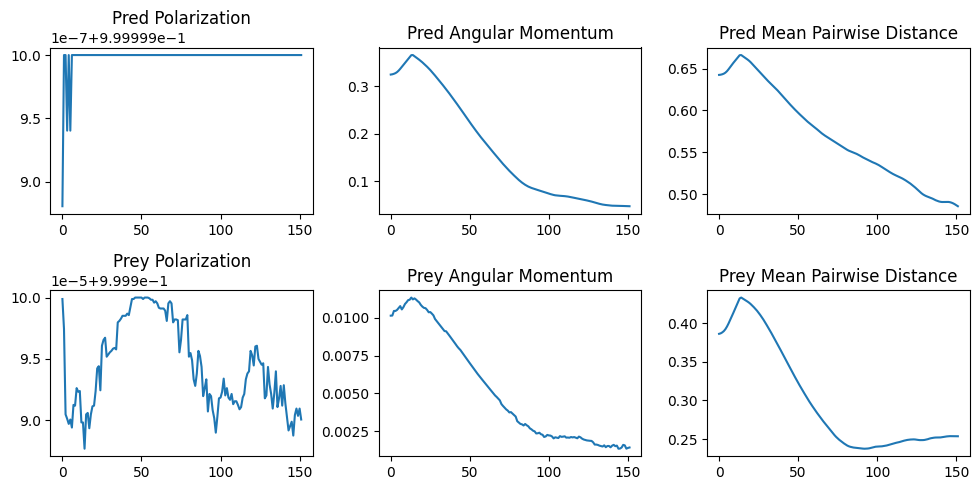

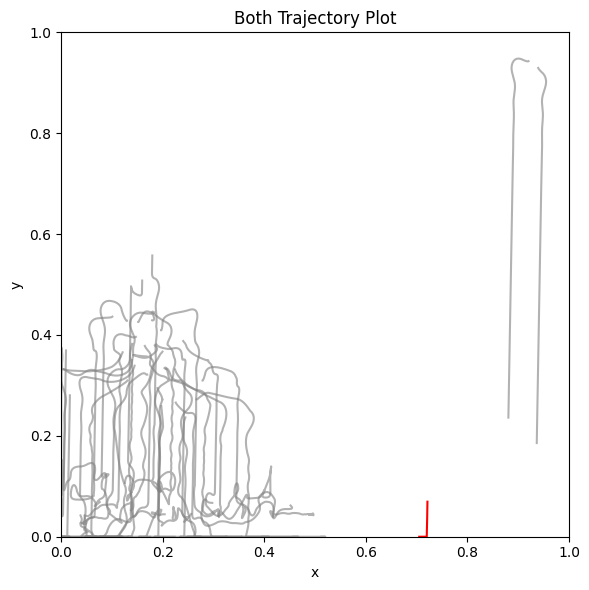

In [7]:
print("Pred Mean Polarization: ", np.mean([m["polarization"][0] for m in metrics]))
print("Prey Mean Polarization:", np.mean([m["polarization"][1] for m in metrics]))

print("\nPred Mean Angular Momentum: ", np.mean([m["angular_momentum"][0] for m in metrics]))
print("Prey Mean Angular Momentum:", np.mean([m["angular_momentum"][1] for m in metrics]))

print("\nPred Mean Pairwise Distance: ", np.mean([m["mean_pairwise_distance"][0] for m in metrics]))
print("Prey Mean Pairwise Distance:", np.mean([m["mean_pairwise_distance"][1] for m in metrics]))

plot_metrics(metrics)

plot_trajectory(metrics, role='both')

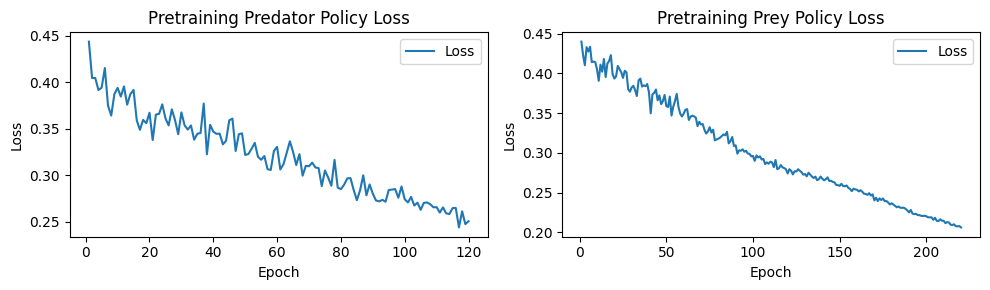

In [8]:
plot_pretraining(logs_pretrain_pred, logs_pretrain_prey)

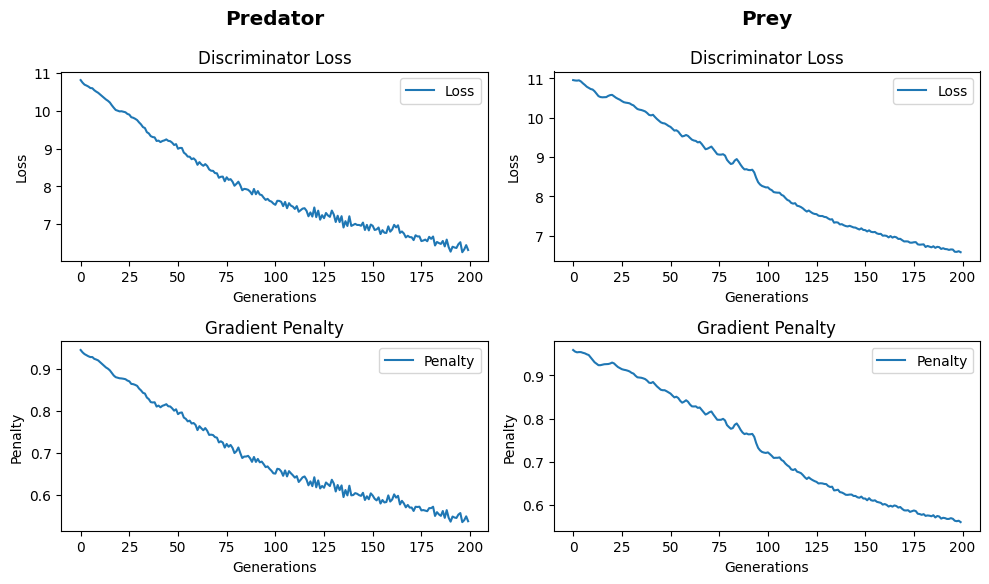

In [9]:
evaluate_discriminator(dis_metrics_pred, dis_metrics_prey)

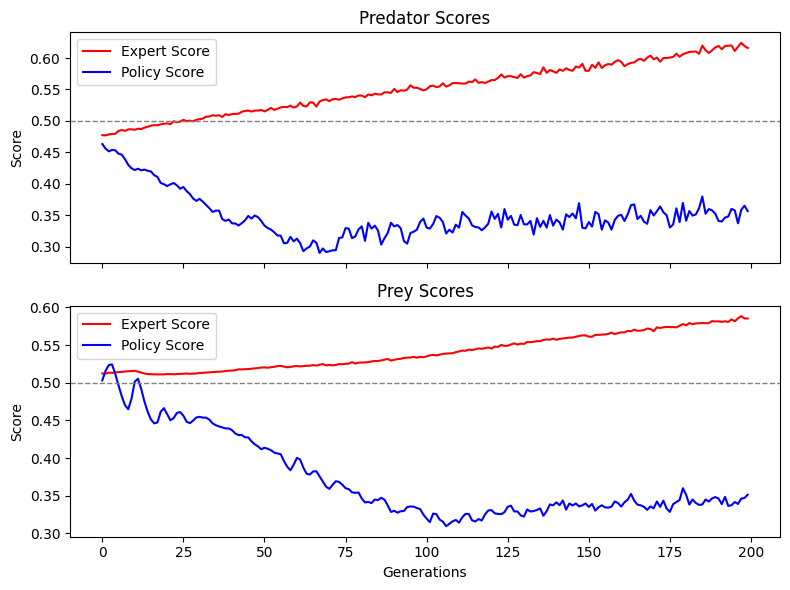

In [10]:
plot_scores(dis_metrics_pred, dis_metrics_prey)

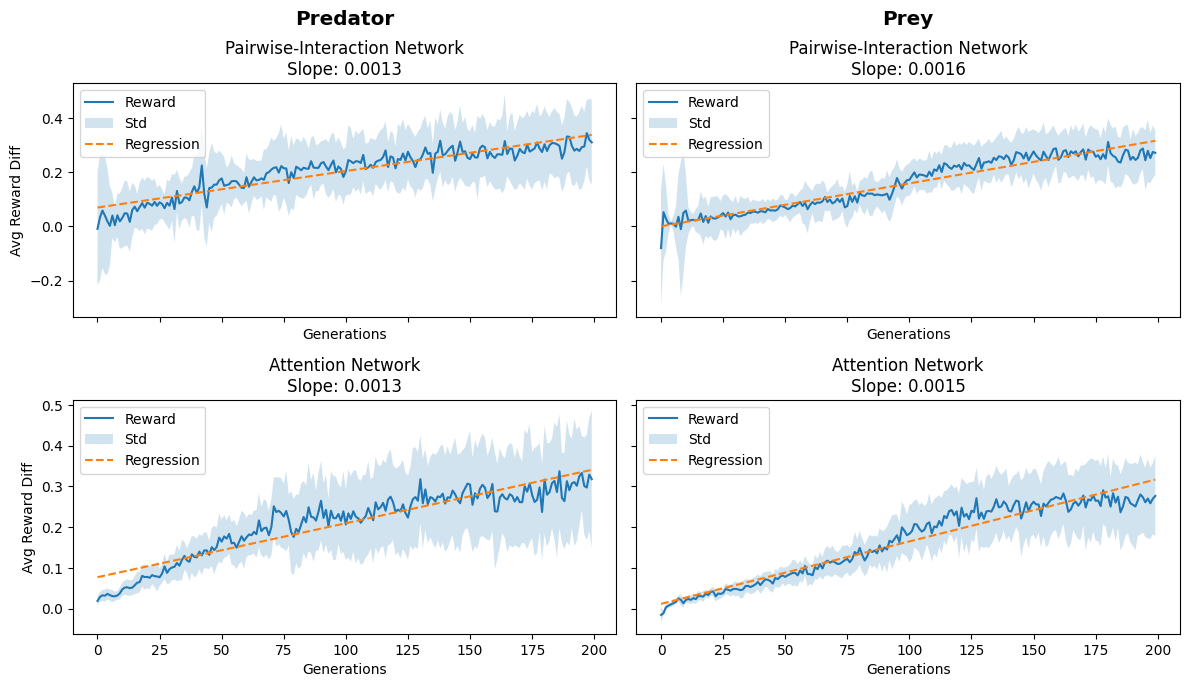

In [11]:
evaluate_es(es_metrics_pred, es_metrics_prey)

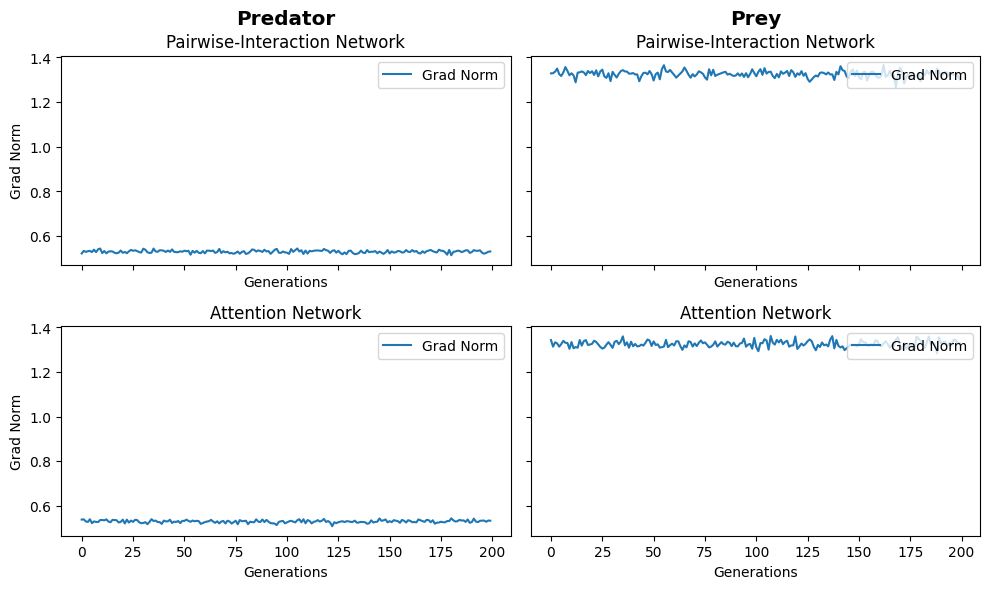

In [12]:
plot_grad_norm(es_metrics_pred, es_metrics_prey)